Lựa chọn thuật toán phù hợp trong môn Big Data
Machine Learning    
(chọn ít nhất 2 thuật toán để thực hiện
và đánh giá)

In [39]:
import findspark
findspark.init()
import pyspark

In [66]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import time
from pyspark.sql import functions as F

In [41]:
# Tạo SparkSession
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

In [42]:
df = spark.read.csv('Danh_gia_cleaned_updated.csv', header=True, inferSchema=True)

In [43]:
# Hiển thị dữ liệu
df.show(10)

+-------------+--------------------+--------------+-------------+------+-----------+--------------------+
|ma_khach_hang|  noi_dung_binh_luan|ngay_binh_luan|gio_binh_luan|so_sao|ma_san_pham|         content_new|
+-------------+--------------------+--------------+-------------+------+-----------+--------------------+
|          443|SỬ DỤNG DỄ DÀNG, ...|    29/04/2023|        17:06|     5|  308500015|   dễ_dàng thoải_mái|
|         1030|Sử dụng dễ dãng,r...|    30/04/2023|        15:04|     5|  308500015|   dễ_dàng thoải_mái|
|          689|Mình rất thích ha...|    30/04/2023|        18:34|     5|  422216594|    thích hasaki_tẩy|
|         2519|Sản phẩm có khả n...|    17/07/2022|        13:48|     5|  204100075|sạch tốt loại_bỏ ...|
|          402|Sữa rửa mặt tốt,s...|    15/04/2023|        23:04|     5|  422208977|    rửa tốt sạch mịn|
|         2517|Sau 77 49 dòng sr...|    25/12/2022|        17:11|     5|  204100019|chân_ái thử khô k...|
|         1750|Đó giờ mình sài b...|      9/7/

In [44]:
df.withColumn('sentiment',when(df['so_sao']>3,'Positive').otherwise('Negative')).show(15)

+-------------+--------------------+--------------+-------------+------+-----------+--------------------+---------+
|ma_khach_hang|  noi_dung_binh_luan|ngay_binh_luan|gio_binh_luan|so_sao|ma_san_pham|         content_new|sentiment|
+-------------+--------------------+--------------+-------------+------+-----------+--------------------+---------+
|          443|SỬ DỤNG DỄ DÀNG, ...|    29/04/2023|        17:06|     5|  308500015|   dễ_dàng thoải_mái| Positive|
|         1030|Sử dụng dễ dãng,r...|    30/04/2023|        15:04|     5|  308500015|   dễ_dàng thoải_mái| Positive|
|          689|Mình rất thích ha...|    30/04/2023|        18:34|     5|  422216594|    thích hasaki_tẩy| Positive|
|         2519|Sản phẩm có khả n...|    17/07/2022|        13:48|     5|  204100075|sạch tốt loại_bỏ ...| Positive|
|          402|Sữa rửa mặt tốt,s...|    15/04/2023|        23:04|     5|  422208977|    rửa tốt sạch mịn| Positive|
|         2517|Sau 77 49 dòng sr...|    25/12/2022|        17:11|     5|

In [45]:
# gắn lại biến sentiment cho df

df = df.withColumn('sentiment', when(df['so_sao'] > 3, 'Positive').otherwise('Negative'))


In [46]:
df.show(15)

+-------------+--------------------+--------------+-------------+------+-----------+--------------------+---------+
|ma_khach_hang|  noi_dung_binh_luan|ngay_binh_luan|gio_binh_luan|so_sao|ma_san_pham|         content_new|sentiment|
+-------------+--------------------+--------------+-------------+------+-----------+--------------------+---------+
|          443|SỬ DỤNG DỄ DÀNG, ...|    29/04/2023|        17:06|     5|  308500015|   dễ_dàng thoải_mái| Positive|
|         1030|Sử dụng dễ dãng,r...|    30/04/2023|        15:04|     5|  308500015|   dễ_dàng thoải_mái| Positive|
|          689|Mình rất thích ha...|    30/04/2023|        18:34|     5|  422216594|    thích hasaki_tẩy| Positive|
|         2519|Sản phẩm có khả n...|    17/07/2022|        13:48|     5|  204100075|sạch tốt loại_bỏ ...| Positive|
|          402|Sữa rửa mặt tốt,s...|    15/04/2023|        23:04|     5|  422208977|    rửa tốt sạch mịn| Positive|
|         2517|Sau 77 49 dòng sr...|    25/12/2022|        17:11|     5|

In [47]:
# Chuyển đổi nhãn thành số
label_indexer = StringIndexer(inputCol="sentiment", outputCol="label")

# Tokenize văn bản
tokenizer = Tokenizer(inputCol="noi_dung_binh_luan", outputCol="words")

# Loại bỏ stopword

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Vector hóa bằng CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
# Áp dụng TF-IDF
idf = IDF(inputCol="raw_features", outputCol="features")

In [48]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
train, test = df.randomSplit([0.8, 0.2], seed=42)

In [90]:
# 1. Logistic Regression
logistic_regression = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)

# 2. Random Forest
random_forest = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

In [93]:
# Đánh giá mô hình
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [94]:
# Pipeline cho Logistic Regression
start_time_1 = time.time()
pipeline_lr = Pipeline(stages=[label_indexer, tokenizer, remover, vectorizer, idf, logistic_regression])
model_lr = pipeline_lr.fit(train)
predictions_lr = model_lr.transform(test)
accuracy_lr = evaluator.evaluate(predictions_lr)
end_time_1 = time.time()
execution_time_1 = end_time_1 - start_time_1
print("Logistic Regression Accuracy:", accuracy_lr)
print(f"Thời gian chạy thuật toán 1: {execution_time_1:.4f} giây")

Logistic Regression Accuracy: 0.9765108881820406
Thời gian chạy thuật toán 1: 2.8525 giây


In [96]:
# Pipeline cho Random Forest
start_time_2 = time.time()
pipeline_rf = Pipeline(stages=[label_indexer, tokenizer, remover, vectorizer, idf, random_forest])
model_rf = pipeline_rf.fit(train)
predictions_rf = model_rf.transform(test)
accuracy_rf = evaluator.evaluate(predictions_rf)
end_time_2 = time.time()
execution_time_2 = end_time_2 - start_time_2
print("Random Forest Accuracy:", accuracy_rf)
print(f"Thời gian chạy thuật toán 2: {execution_time_2:.4f} giây")

Random Forest Accuracy: 0.9057988744800587
Thời gian chạy thuật toán 2: 10.5463 giây


In [67]:
def calculate_confusion_matrix(predictions):
    # So sánh dự đoán và nhãn thực tế
    cm = predictions.groupBy('label', 'prediction').count().withColumnRenamed('count', 'TP_FPs')
    
    # Tạo confusion matrix
    cm = cm.withColumn(
        'TP', F.when((cm['label'] == cm['prediction']) & (cm['label'] == 1), cm['TP_FPs']).otherwise(0)
    ).withColumn(
        'TN', F.when((cm['label'] == cm['prediction']) & (cm['label'] == 0), cm['TP_FPs']).otherwise(0)
    ).withColumn(
        'FP', F.when((cm['label'] != cm['prediction']) & (cm['label'] == 0), cm['TP_FPs']).otherwise(0)
    ).withColumn(
        'FN', F.when((cm['label'] != cm['prediction']) & (cm['label'] == 1), cm['TP_FPs']).otherwise(0)
    )

    # Tính tổng các ô confusion matrix
    cm = cm.groupBy().agg(
        F.sum('TP').alias('True Positive'),
        F.sum('TN').alias('True Negative'),
        F.sum('FP').alias('False Positive'),
        F.sum('FN').alias('False Negative')
    )
    return cm

# Confusion Matrix cho Logistic Regression
cm_lr = calculate_confusion_matrix(predictions_lr)
cm_lr.show()


+-------------+-------------+--------------+--------------+
|True Positive|True Negative|False Positive|False Negative|
+-------------+-------------+--------------+--------------+
|          341|         3650|            52|            44|
+-------------+-------------+--------------+--------------+



In [69]:
# Tính toán confusion matrix cho Random Forest
cm_rf = calculate_confusion_matrix(predictions_rf)
cm_rf.show()

+-------------+-------------+--------------+--------------+
|True Positive|True Negative|False Positive|False Negative|
+-------------+-------------+--------------+--------------+
|            0|         3702|             0|           385|
+-------------+-------------+--------------+--------------+



In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [72]:
# Hàm vẽ confusion matrix
def plot_confusion_matrix(cm, labels, model_name):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [73]:
# Lấy các giá trị của confusion matrix từ DataFrame
cm_lr_values = cm_lr.collect()[0]
cm_rf_values = cm_rf.collect()[0]

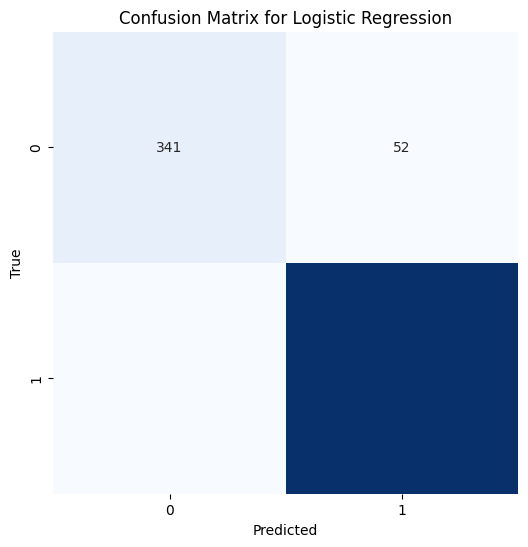

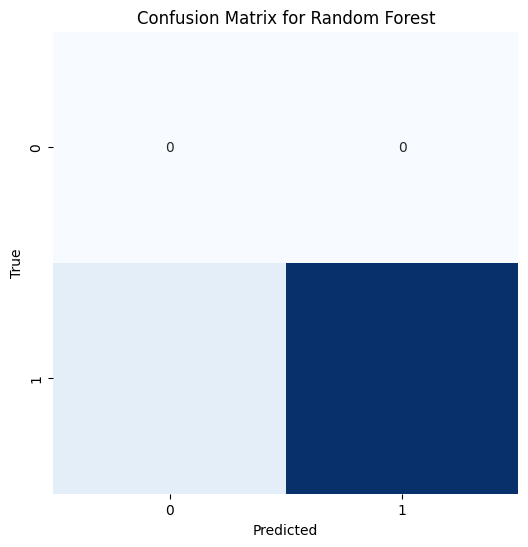

In [78]:
# Biểu diễn confusion matrix dưới dạng mảng numpy
cm_lr_array = np.array([[cm_lr_values['True Positive'], cm_lr_values['False Positive']],
                        [cm_lr_values['False Negative'], cm_lr_values['True Negative']]])

cm_rf_array = np.array([[cm_rf_values['True Positive'], cm_rf_values['False Positive']],
                        [cm_rf_values['False Negative'], cm_rf_values['True Negative']]])

# Lấy các nhãn (0 và 1 cho nhị phân)
labels = ['0', '1']

# Vẽ confusion matrix cho Logistic Regression
plot_confusion_matrix(cm_lr_array, labels, 'Logistic Regression')
# Vẽ confusion matrix cho Randomforest
plot_confusion_matrix(cm_rf_array, labels, 'Random Forest')